Step2: Embedding-based Model (all-MiniLM-L6-v2 + lightGBM), pulic score: 1.03647

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip install sentence-transformers lightgbm pandas numpy
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentencetransformersallminilml6v2/config.json
/kaggle/input/sentencetransformersallminilml6v2/tokenizer.json
/kaggle/input/sentencetransformersallminilml6v2/tokenizer_config.json
/kaggle/input/sentencetransformersallminilml6v2/pytorch_model.bin
/kaggle/input/sentencetransformersallminilml6v2/special_tokens_map.json
/kaggle/input/sentencetransformersallminilml6v2/vocab.txt
/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
^C


In [3]:
# --- 1. data load ---
import warnings


warnings.filterwarnings('ignore')


DATA_PATH = "/kaggle/input/llm-classification-finetuning/"

try:
    train_df = pd.read_csv(f"{DATA_PATH}train.csv")
    test_df = pd.read_csv(f"{DATA_PATH}test.csv")
    sample_submission_df = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

    print(f"학습 데이터 크기: {train_df.shape}")
    print(f"테스트 데이터 크기: {test_df.shape}")

except FileNotFoundError:
    print(f"오류: 캐글 데이터셋 경로({DATA_PATH})를 찾을 수 없습니다.")


학습 데이터 크기: (57477, 9)
테스트 데이터 크기: (3, 4)


In [4]:
# --- 2. create target variables(y_train) ---
import pandas as pd
import numpy as np
# 'winner_model_a', 'winner_model_b', 'winner_model_tie' to
# 0, 1, 2 (a, b, tie) format
target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
# np.argmax [1, 0, 0] -> 0, [0, 1, 0] -> 1, [0, 0, 1] -> 2
y_train = np.argmax(train_df[target_cols].values, axis=1)

print("\n타겟 변수(y_train) 생성 완료.")
print(f"y_train 분포:\n{pd.Series(y_train).value_counts(normalize=True)}")


타겟 변수(y_train) 생성 완료.
y_train 분포:
0    0.349079
1    0.341911
2    0.309011
Name: proportion, dtype: float64


In [5]:
!ls -al /kaggle/input/sentencetransformersallminilml6v2

total 89700
drwxr-xr-x 2 nobody nogroup        0 Oct 29 17:19 .
drwxr-xr-x 4 root   root        4096 Nov  5 15:37 ..
-rw-r--r-- 1 nobody nogroup      678 Oct 29 17:19 config.json
-rw-r--r-- 1 nobody nogroup 90890157 Oct 29 17:20 pytorch_model.bin
-rw-r--r-- 1 nobody nogroup      125 Oct 29 17:19 special_tokens_map.json
-rw-r--r-- 1 nobody nogroup      570 Oct 29 17:19 tokenizer_config.json
-rw-r--r-- 1 nobody nogroup   711661 Oct 29 17:19 tokenizer.json
-rw-r--r-- 1 nobody nogroup   231508 Oct 29 17:19 vocab.txt


In [6]:
# --- 3. load embedding model ---
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np


MODEL_PATH = "/kaggle/input/sentencetransformersallminilml6v2"

print(f"\n임베딩 모델 로드 중... (로컬 경로: {MODEL_PATH})")

try:
    embedding_model = SentenceTransformer(
        MODEL_PATH,
        device='cuda',
        local_files_only=True,
        tokenizer_kwargs={"chat_template": None}
    )
    print("모델 로드 완료.")

except OSError:
    print(f"오류: {MODEL_PATH} 경로에 모델이 없습니다.")
    print("오른쪽 'Add Data'에서 'sentence-transformers/all-minilm-l6-v2' 데이터셋을 추가했는지 확인하세요.")
    raise Exception("모델 로드 실패. 캐글 데이터셋을 추가하세요.")

print("모델 로드 완료.")

# --- 4. create text embedding ---
def get_embeddings(df, model):
    print(f"총 {len(df)}개의 데이터 임베딩 생성 중...")
    
    prompts = df['prompt'].tolist()
    responses_a = df['response_a'].tolist()
    responses_b = df['response_b'].tolist()
    
    print("Prompt 임베딩 중...")
    prompt_emb = model.encode(prompts, show_progress_bar=True, device='cuda')
    print("Response A 임베딩 중...")
    resp_a_emb = model.encode(responses_a, show_progress_bar=True, device='cuda')
    print("Response B 임베딩 중...")
    resp_b_emb = model.encode(responses_b, show_progress_bar=True, device='cuda')
    
    return prompt_emb, resp_a_emb, resp_b_emb

# --- 5. feature(X) function ---
def create_features(prompt_emb, resp_a_emb, resp_b_emb):
    diff_emb = resp_a_emb - resp_b_emb
    prod_emb = resp_a_emb * resp_b_emb
    
    # (prompt, resp_a, resp_b, a-b, a*b)
    features = np.concatenate([
        prompt_emb,
        resp_a_emb,
        resp_b_emb,
        diff_emb,
        prod_emb
    ], axis=1)
    
    return features

train_prompt_emb, train_resp_a_emb, train_resp_b_emb = get_embeddings(train_df, embedding_model)
X_train_features = create_features(train_prompt_emb, train_resp_a_emb, train_resp_b_emb)

print(f"학습 피처 행렬 크기: {X_train_features.shape}") # (n_samples, 384 * 5)

test_prompt_emb, test_resp_a_emb, test_resp_b_emb = get_embeddings(test_df, embedding_model)
X_test_features = create_features(test_prompt_emb, test_resp_a_emb, test_resp_b_emb)

print(f"테스트 피처 행렬 크기: {X_test_features.shape}")

2025-11-05 15:41:32.380156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762357292.574286      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762357292.629050      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



임베딩 모델 로드 중... (로컬 경로: /kaggle/input/sentencetransformersallminilml6v2)
모델 로드 완료.
모델 로드 완료.
총 57477개의 데이터 임베딩 생성 중...
Prompt 임베딩 중...


Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Response A 임베딩 중...


Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Response B 임베딩 중...


Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

학습 피처 행렬 크기: (57477, 1920)
총 3개의 데이터 임베딩 생성 중...
Prompt 임베딩 중...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response A 임베딩 중...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response B 임베딩 중...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

테스트 피처 행렬 크기: (3, 1920)


In [7]:
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
# --- 6. fit classifier model (LightGBM) ---
print("\nLightGBM 모델 학습 시작...")


lgb_classifier = lgb.LGBMClassifier(
    objective='multiclass',  # (a, b, tie)
    metric='multi_logloss',  
    num_class=3,             # class count (0, 1, 2)
    random_state=42,
    n_estimators=300,        
    learning_rate=0.03,      # lr
    num_leaves=31,           # # of leaf node
    device='gpu'
    # n_jobs=-1                # use all gpus
)

lgb_classifier.fit(X_train_features, y_train)

print("모델 학습 완료.")



LightGBM 모델 학습 시작...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 489090
[LightGBM] [Info] Number of data points in the train set: 57477, number of used features: 1918
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1918 dense feature groups (105.24 MB) transferred to GPU in 0.099588 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.052458
[LightGBM] [Info] Start training from score -1.073206
[LightGBM] [Info] Start training from score -1.174380
모델 학습 완료.


In [34]:
# --- 7. prediction ---
print("테스트 데이터로 예측 수행 중...")
test_probabilities = lgb_classifier.predict_proba(X_test_features)

print("예측 완료.")
print(['winner_model_a', 'winner_model_b', 'winner_model_tie'])
print(test_probabilities)


# --- 8. make submission file ---
print("\n제출 파일(submission.csv) 생성 중...")


submission_df = pd.DataFrame({'id': test_df['id']})
submission_df['winner_model_a'] = test_probabilities[:, 0]  # probability of class 0 (a)
submission_df['winner_model_b'] = test_probabilities[:, 1]  # probability of class 1 (b)
submission_df['winner_model_tie'] = test_probabilities[:, 2]  # probability of class 2 (tie)

submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' 파일이 성공적으로 생성되었습니다.")
print("캐글에 이 파일을 제출하여 Step 2 점수를 확인하세요!")

print("\n--- 스크립트 종료 ---")

테스트 데이터로 예측 수행 중...
예측 완료.
['winner_model_a', 'winner_model_b', 'winner_model_tie']
[[0.2631966  0.28148025 0.45532315]
 [0.35724679 0.39620422 0.24654899]
 [0.28614282 0.45378926 0.26006792]]

제출 파일(submission.csv) 생성 중...

'submission.csv' 파일이 성공적으로 생성되었습니다.
캐글에 이 파일을 제출하여 Step 2 점수를 확인하세요!

--- 스크립트 종료 ---


Step4: Error Analysis

--- Step 4. Error Analysis (On Training Data) ---
Making predictions on training data...

[Quantitative Analysis 1] overall Log Loss (Training): 0.8750

 log loss per class:
'winner_model_a' (0): 0.8363
'winner_model_b' (1): 0.8527
'winner_tie' (2): 0.9432

[Quantitative Analysis 2] creating Confusion Matrix ...
  - Row: True Label
  - Column: Predicted Label


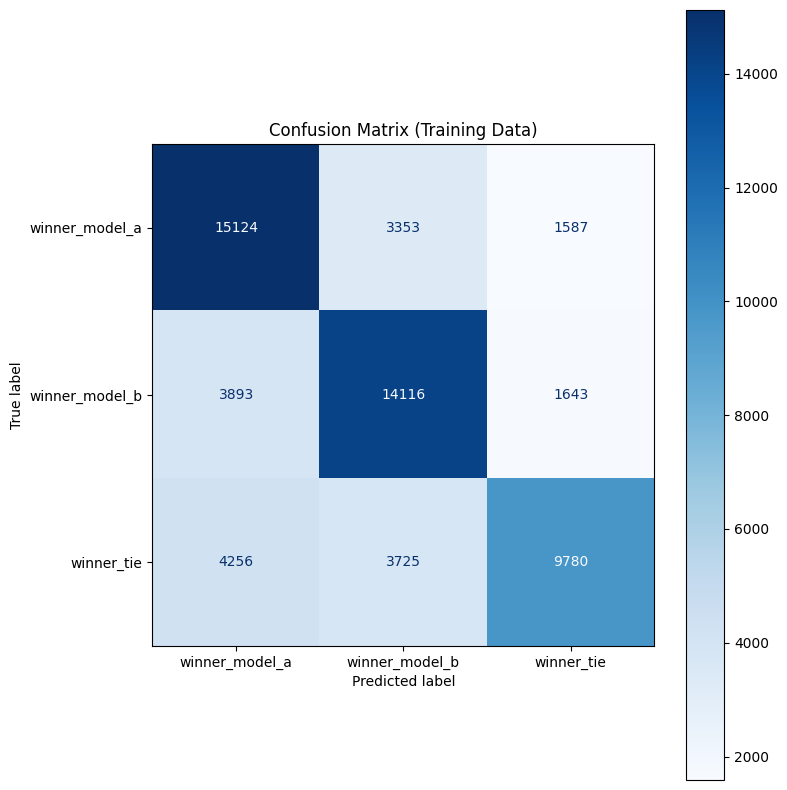


[Quantitative Analysis 3] Classification Report (Precision, Recall, F1-Score)
                precision    recall  f1-score   support

winner_model_a       0.65      0.75      0.70     20064
winner_model_b       0.67      0.72      0.69     19652
    winner_tie       0.75      0.55      0.64     17761

      accuracy                           0.68     57477
     macro avg       0.69      0.67      0.67     57477
  weighted avg       0.69      0.68      0.68     57477



In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Step 4. Error Analysis ---
print("--- Step 4. Error Analysis (On Training Data) ---")

# 0=model_a, 1=model_b, 2=winner_tie
LABELS = ['winner_model_a', 'winner_model_b', 'winner_tie']
CLASS_INDICES = [0, 1, 2]

# --- 1. Make predictions on training data ---
print("Making predictions on training data...")
y_train_pred_proba = lgb_classifier.predict_proba(X_train_features)
y_train_pred_class = lgb_classifier.predict(X_train_features)
y_train_true = y_train

# --- 2. Quantitative Analysis ---

# 2-1. Per-Class Log Loss (& overall Log Loss)
# overall Log Loss
overall_logloss = log_loss(y_train_true, y_train_pred_proba)
print(f"\n[Quantitative Analysis 1] overall Log Loss (Training): {overall_logloss:.4f}")

# Calculating Log Loss by Class
print("\n log loss per class:")
for i in CLASS_INDICES:
    class_mask = (y_train_true == i)
    
    if np.sum(class_mask) == 0:
        print(f"{LABELS[i]}: There are no samples in the data.")
        continue
        
    # The probability values ​​given to the "correct" class for each class sample
    class_true_probas = y_train_pred_proba[class_mask, i]
    
    # Clipping to a very small value (epsilon) to avoid log(0)
    class_true_probas = np.clip(class_true_probas, 1e-15, 1 - 1e-15)
    
    # Calculating the average Negative Log Likelihood (NLL)
    class_avg_nll = -np.mean(np.log(class_true_probas))
    print(f"'{LABELS[i]}' ({i}): {class_avg_nll:.4f}")

# 2-2. Confusion Matrix (혼동 행렬)
print("\n[Quantitative Analysis 2] creating Confusion Matrix ...")
cm = confusion_matrix(y_train_true, y_train_pred_class)

# matplotlib ->  visualize Confusion Matrix
print("  - Row: True Label")
print("  - Column: Predicted Label")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Training Data)")
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

# 2-3. Classification Report (Precision, Recall, F1-Score)
print("\n[Quantitative Analysis 3] Classification Report (Precision, Recall, F1-Score)")

# Compare y_train_true (actual answer) and y_train_pred_class (model's final prediction)
report = classification_report(
    y_train_true, 
    y_train_pred_class, 
    target_names=LABELS
)

print(report)

In [38]:
# --- 3. Qualitative Examples ---
print("\n[Qualitative Analysis] Analyzing misclassified cases...")

# Add prediction results to the original train_df for analysis
train_df_analysis = train_df.copy()
train_df_analysis['true_label'] = y_train_true
train_df_analysis['pred_label'] = y_train_pred_class

# Convert true_label and pred_label to strings
label_map = {i: label for i, label in enumerate(LABELS)}
train_df_analysis['true_label_str'] = train_df_analysis['true_label'].map(label_map)
train_df_analysis['pred_label_str'] = train_df_analysis['pred_label'].map(label_map)

# Filter only misclassified cases
misclassified_df = train_df_analysis[train_df_analysis['true_label'] != train_df_analysis['pred_label']]

print(f"\n # of misclassified training data points: {len(misclassified_df)}\n")
print("--- Top 3 Misclassified Examples ---")

# Set pandas options for better terminal display
pd.set_option('display.max_colwidth', 300)

for i, row in misclassified_df.head(3).iterrows():
    print(f"--- Example (Index: {i}) ---")
    print(f"Prompt:     {row['prompt']}")
    print(f"Response A: {row['response_a']}")
    print(f"Response B: {row['response_b']}")
    
    # Predicted probabilities
    pred_probas = y_train_pred_proba[i]
    proba_str = f"[A: {pred_probas[0]:.3f}, B: {pred_probas[1]:.3f}, Tie: {pred_probas[2]:.3f}]"
    
    print(f"\n==> True Label: {row['true_label_str']} (True: {row['true_label']})")
    print(f"==> Predicted Label: {row['pred_label_str']} (Pred: {row['pred_label']})")
    print(f"    (Predicted Probabilities: {proba_str})")

print("\n--- Error Analysis Complete ---")


[Qualitative Analysis] Analyzing misclassified cases...

 # of misclassified training data points: 18457

--- Top 3 Misclassified Examples ---
--- Example (Index: 2) ---
Prompt:     ["explain function calling. how would you call a function?"]
Response A: ["Function calling is the process of invoking or executing a function in a programming language. To call a function, you need to use the function's name followed by parentheses \"()\". Within the parentheses, you can pass arguments if the function requires any.\n\nHere is an example of how to call a function in Python:\n\n```python\n# Define a function\ndef greet(name):\n    print(\"Hello, \" + name + \"!\")\n\n# Call the function\ngreet(\"John\")\n```\n\nIn this example, the function \"greet\" is defined with a single parameter \"name\" which is used to print a greeting message. To call the function and pass an argument, we write \"greet(\"John\")\". This will execute the function and print \"Hello, John!\".\n\nIt is important to not